### **Import** **Libraries**


---

In [1]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import KFold
from keras.utils import plot_model
from IPython.display import Image

In [2]:
import pydot
from sklearn import __version__ as sklearn_version
from keras import __version__ as keras_version
from IPython import __version__ as ipython_version


print("pydot version: {pydot.__version__}")
print("matplotlib version: {plt.__version__}")
print("OpenCV version:", cv2.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn_version)
print("Keras version:", keras_version)
print("IPython version:", ipython_version)


pydot version: {pydot.__version__}
matplotlib version: {plt.__version__}
OpenCV version: 4.5.5
Pandas version: 1.5.3
NumPy version: 1.21.6
TensorFlow version: 2.10.1
Seaborn version: 0.11.2
Scikit-learn version: 1.0.2
Keras version: 2.10.0
IPython version: 8.4.0


### **Image Path Declearation and dividing test and Traning 9:1**

---




In [3]:
image_directory = r'C:\Users\Jardani\Desktop\Venus Folder\256_Size_Object_Classification_Images'

In [4]:
class_labels = sorted(os.listdir(image_directory))

with open('class_labels.txt', 'w') as file:
    for label in class_labels:
        file.write(label + '\n')

print("Class Labels:", class_labels)

Class Labels: ['Bike', 'Car', 'Cat', 'Chair', 'Cup', 'Dog', 'Person', 'Sofa']


In [5]:
def get_image_paths_and_labels(image_directory):
    classes = [d for d in os.listdir(image_directory) if os.path.isdir(os.path.join(image_directory, d))]
    file_paths = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(image_directory, class_name)
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        file_paths.extend([os.path.join(class_dir, image) for image in images])
        labels.extend([class_name] * len(images))

    return file_paths, labels

In [6]:
def shuffle_and_split_data(file_paths, labels, test_ratio=0.1):
    data = list(zip(file_paths, labels))
    random.shuffle(data)
    file_paths, labels = zip(*data)

    split_index = int(len(file_paths) * (1 - test_ratio))
    train_paths, test_paths = file_paths[:split_index], file_paths[split_index:]
    train_labels, test_labels = labels[:split_index], labels[split_index:]

    return train_paths, train_labels, test_paths, test_labels

In [7]:
file_paths, labels = get_image_paths_and_labels(image_directory)

In [8]:
train_paths, train_labels, test_paths, test_labels = shuffle_and_split_data(file_paths, labels, test_ratio=0.1)

In [9]:
train_val_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})


### **Declearing Image Size And Epochs**

---



In [10]:
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
BATCH_SIZE = 32
EPOCHS = 100
K = 5

NUM_CLASSES = len(class_labels)


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)

### **K-Fold > Traning**

---



In [13]:
kf = KFold(n_splits=5, shuffle=True)
fold_no = 1
all_train_histories = []

for train_index, val_index in kf.split(train_val_df):
    print(f'Fold {fold_no}')

    train_df = train_val_df.iloc[train_index]
    validation_df = train_val_df.iloc[val_index]

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        validation_df,
        x_col='filename',
        y_col='class',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    model = Sequential([
      InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3)),
      Conv2D(16, (3, 3), activation='relu'),
      Conv2D(16, (3, 3), activation='relu'),
      MaxPooling2D((2, 2), strides=2),
      Conv2D(32, (3, 3), activation='relu'),
      Conv2D(32, (3, 3), activation='relu'),
      MaxPooling2D((2, 2), strides=2),
      Conv2D(64, (3, 3), activation='relu'),
      Conv2D(64, (3, 3), activation='relu'),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2), strides=2),
      Conv2D(128, (3, 3), activation='relu'),
      Conv2D(128, (3, 3), activation='relu'),
      Conv2D(128, (3, 3), activation='relu'),
      GlobalAveragePooling2D(),
      Dense(128, activation='relu'),
      Dropout(0.2),
      Dense(NUM_CLASSES, activation='softmax')
  ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_path = f'model_fold_{fold_no}.h5'
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping]
    )

    all_train_histories.append(history.history)

    best_model = load_model(checkpoint_path)

    scores = best_model.evaluate(validation_generator)
    print(f'Score for fold {fold_no}: {best_model.metrics_names[0]} of {scores[0]}; {best_model.metrics_names[1]} of {scores[1]*100}%')

    fold_no += 1

Fold 1
Found 10828 validated image filenames belonging to 8 classes.
Found 2708 validated image filenames belonging to 8 classes.
Epoch 1/100
339/339 [==============================] - ETA: 0s - loss: 1.9966 - accuracy: 0.1742
Epoch 1: val_accuracy improved from -inf to 0.24040, saving model to model_fold_1.h5
339/339 [==============================] - 92s 257ms/step - loss: 1.9966 - accuracy: 0.1742 - val_loss: 1.7873 - val_accuracy: 0.2404
Epoch 2/100
339/339 [==============================] - ETA: 0s - loss: 1.6406 - accuracy: 0.3584
Epoch 2: val_accuracy improved from 0.24040 to 0.45790, saving model to model_fold_1.h5
339/339 [==============================] - 89s 261ms/step - loss: 1.6406 - accuracy: 0.3584 - val_loss: 1.4746 - val_accuracy: 0.4579
Epoch 3/100
339/339 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.4847
Epoch 3: val_accuracy improved from 0.45790 to 0.54727, saving model to model_fold_1.h5
339/339 [==============================] - 90s 265

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 conv2d_41 (Conv2D)          (None, 252, 252, 16)      2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 124, 124, 32)      4640      
                                                                 
 conv2d_43 (Conv2D)          (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                 

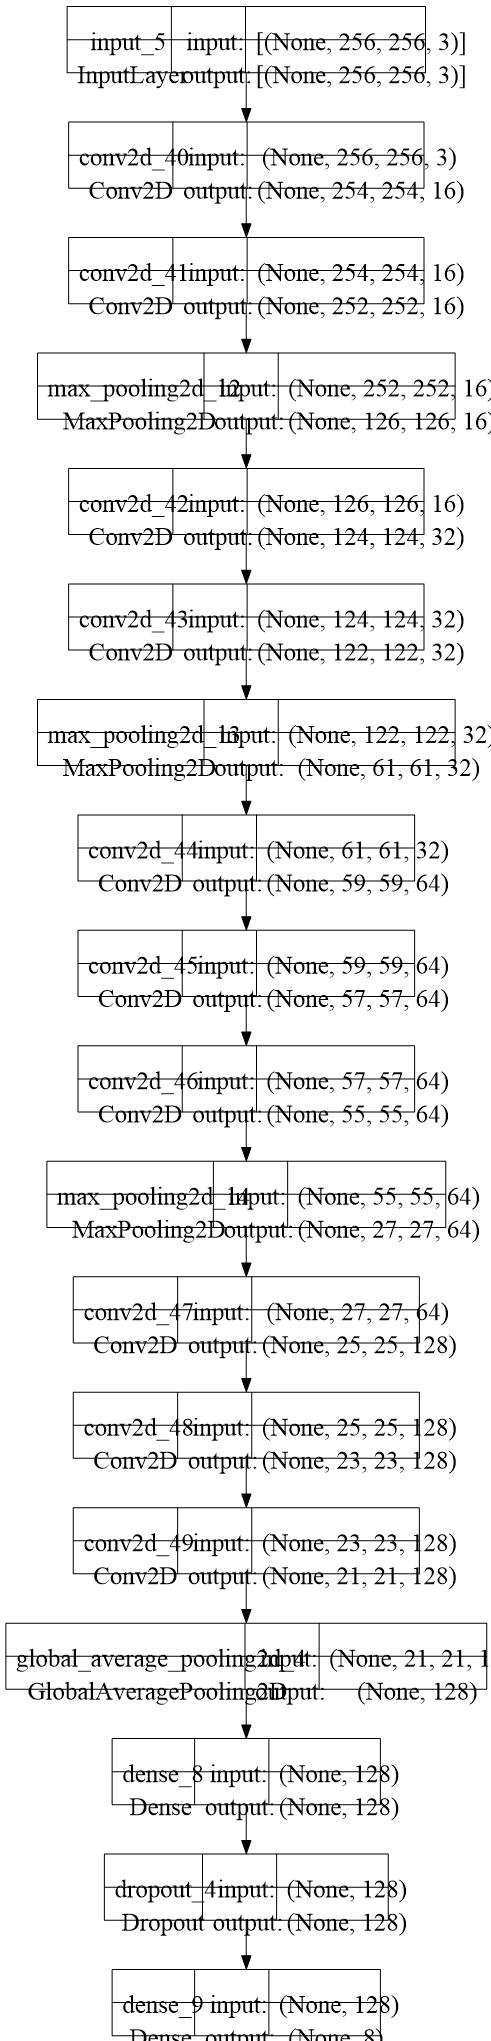

In [14]:
model.summary()

model_summary_file = f'model_summary.txt'
with open(model_summary_file, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

dot_model = model_to_dot(model, show_shapes=True, show_layer_names=True)

dot_model.write_png(f"model_summary.png")

Image(f"model_summary.png")

In [15]:
def plot_history(history, fold_no):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model accuracy for fold {fold_no}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'accuracy_fold_{fold_no}.png')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Model loss for fold {fold_no}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'loss_fold_{fold_no}.png')
    
    plt.show()
    plt.close()

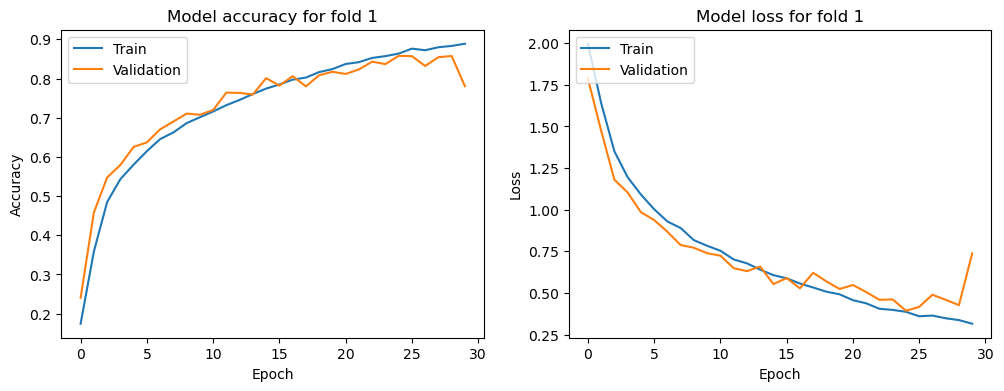

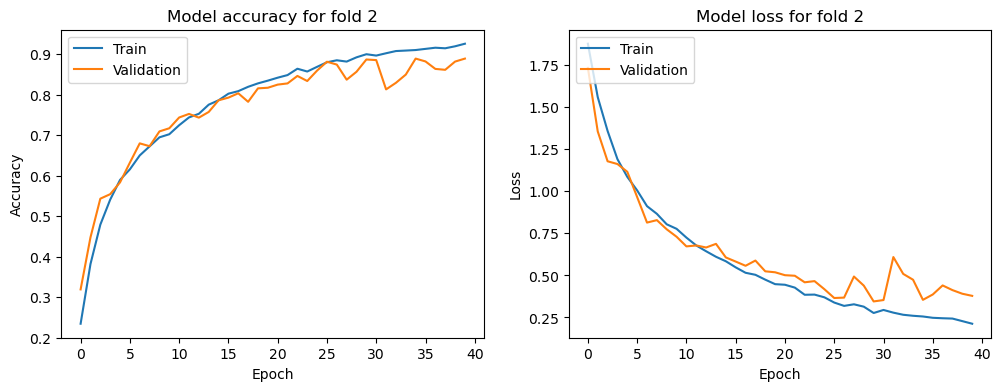

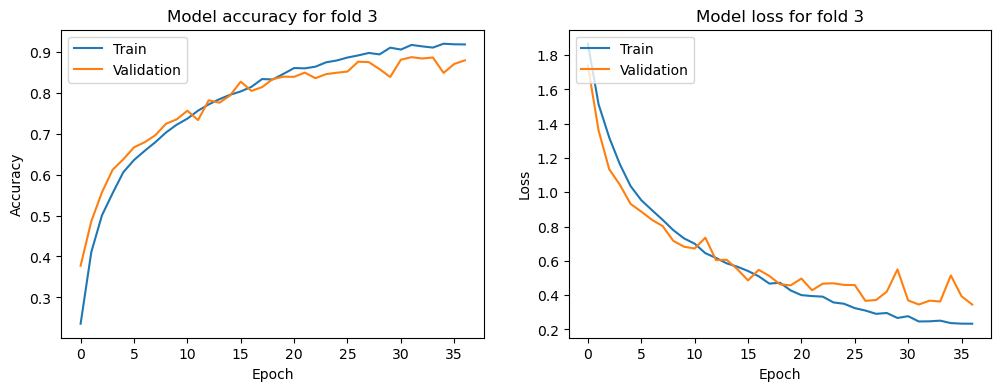

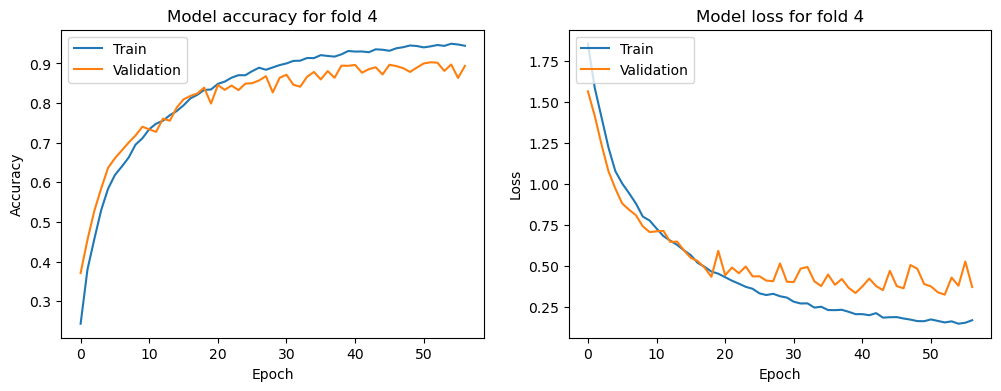

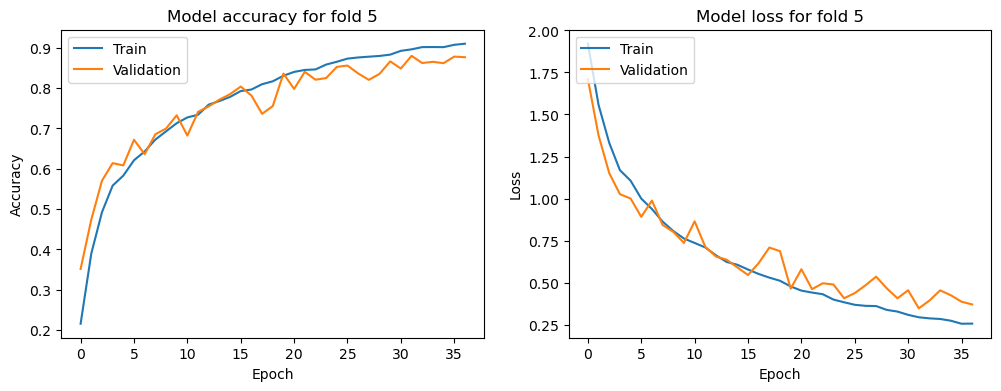

In [16]:
for i, history in enumerate(all_train_histories):
    plot_history(history, i+1)

In [17]:
best_val_accuracy = 0.0
best_model_path = None
total_val_accuracy = 0.0

for Fold_No in range(K):
    checkpoint_path = f'model_fold_{Fold_No+1}.h5'
    model = load_model(checkpoint_path)

    validation_generator = validation_datagen.flow_from_dataframe(
        validation_df,
        x_col='filename',
        y_col='class',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    scores = model.evaluate(validation_generator)
    val_accuracy = scores[1]
    total_val_accuracy += val_accuracy

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_path = checkpoint_path

print(f'Best validation accuracy: {best_val_accuracy}')
average_val_accuracy = total_val_accuracy / K
print(f'Average validation accuracy: {average_val_accuracy}')

best_model.save("Best_Model.h5")

best_model = load_model("Best_Model.h5")

Found 2707 validated image filenames belonging to 8 classes.
85/85 [==============================] - 3s 30ms/step - loss: 0.2573 - accuracy: 0.9076
Found 2707 validated image filenames belonging to 8 classes.
85/85 [==============================] - 3s 29ms/step - loss: 0.1679 - accuracy: 0.9383
Found 2707 validated image filenames belonging to 8 classes.
85/85 [==============================] - 3s 30ms/step - loss: 0.1518 - accuracy: 0.9487
Found 2707 validated image filenames belonging to 8 classes.
85/85 [==============================] - 3s 30ms/step - loss: 0.1032 - accuracy: 0.9668
Found 2707 validated image filenames belonging to 8 classes.
85/85 [==============================] - 3s 29ms/step - loss: 0.3472 - accuracy: 0.8799
Best validation accuracy: 0.9667528867721558
Average validation accuracy: 0.92826007604599


In [18]:
test_generator = validation_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1504 validated image filenames belonging to 8 classes.


In [19]:
test_scores = best_model.evaluate(test_generator)
print(f'Test set score: {best_model.metrics_names[0]} of {test_scores[0]}; {best_model.metrics_names[1]} of {test_scores[1]*100}%')


47/47 [==============================] - 2s 37ms/step - loss: 0.3297 - accuracy: 0.8896
Test set score: loss of 0.3297349214553833; accuracy of 88.96276354789734%


### **CONFUSION MATRIX

---

In [20]:
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

47/47 [==============================] - 1s 29ms/step


In [21]:
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())

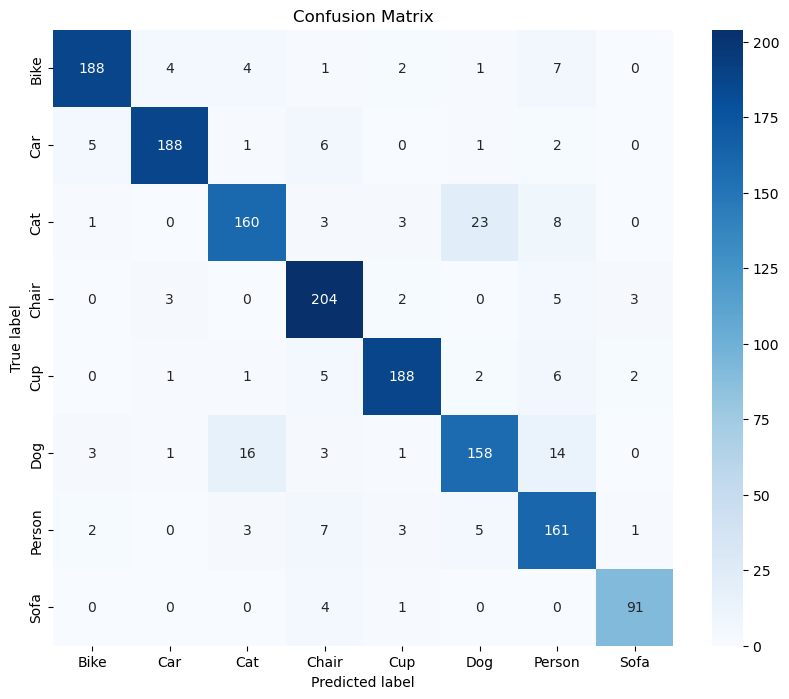

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')


In [23]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
with open('classification_report.txt', 'w') as f:
    f.write(report)

In [24]:
print(report)

              precision    recall  f1-score   support

        Bike       0.94      0.91      0.93       207
         Car       0.95      0.93      0.94       203
         Cat       0.86      0.81      0.84       198
       Chair       0.88      0.94      0.91       217
         Cup       0.94      0.92      0.93       205
         Dog       0.83      0.81      0.82       196
      Person       0.79      0.88      0.84       182
        Sofa       0.94      0.95      0.94        96

    accuracy                           0.89      1504
   macro avg       0.89      0.89      0.89      1504
weighted avg       0.89      0.89      0.89      1504



### **TESTING**

---



1/1 [==============================] - 0s 271ms/step


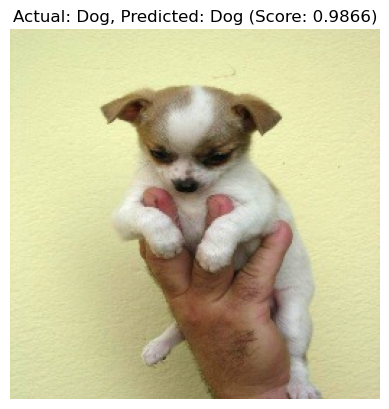

1/1 [==============================] - 0s 12ms/step


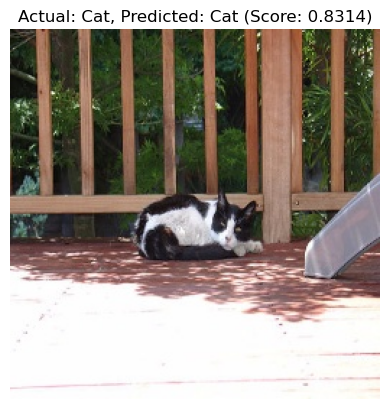

1/1 [==============================] - 0s 13ms/step


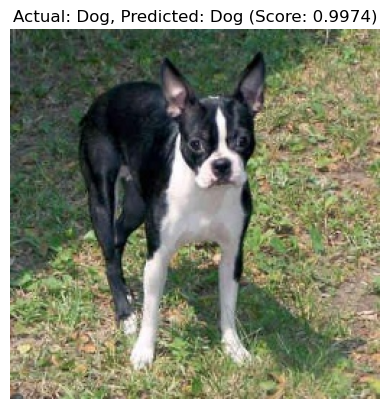

1/1 [==============================] - 0s 13ms/step


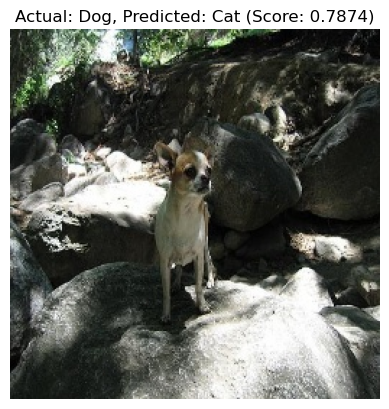

1/1 [==============================] - 0s 15ms/step


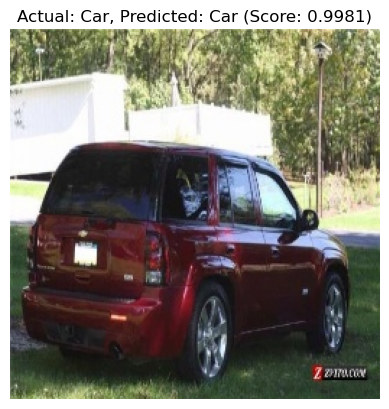

1/1 [==============================] - 0s 12ms/step


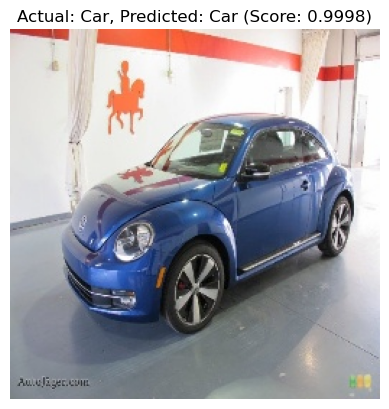

1/1 [==============================] - 0s 12ms/step


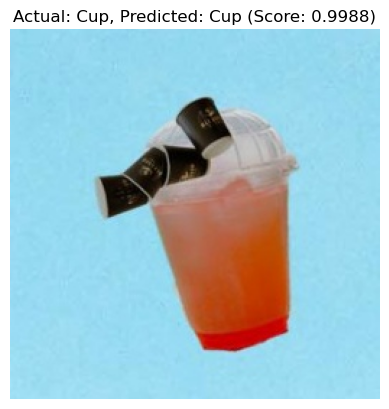

1/1 [==============================] - 0s 13ms/step


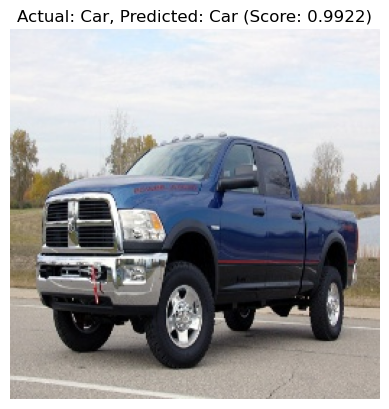

1/1 [==============================] - 0s 13ms/step


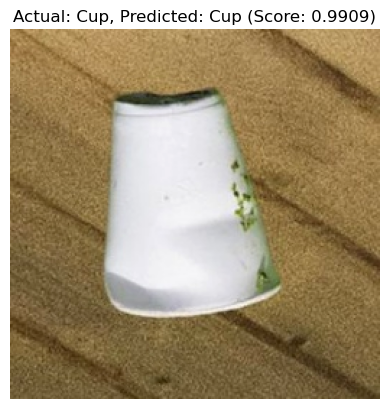

1/1 [==============================] - 0s 13ms/step


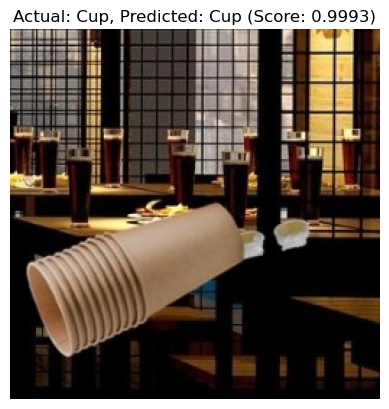

                                               Image Actual Class  \
0  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Dog   
1  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Cat   
2  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Dog   
3  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Dog   
4  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Car   
5  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Car   
6  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Cup   
7  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Car   
8  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Cup   
9  C:\Users\Jardani\Desktop\Venus Folder\256_Size...          Cup   

  Predicted Class  Prediction Score  
0             Dog          0.986579  
1             Cat          0.831399  
2             Dog          0.997417  
3             Cat          0.787386  
4             Car          0.998092  
5           

In [25]:
def load_and_preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

random_indices = random.sample(range(len(test_df)), 10)
random_images = test_df.iloc[random_indices]

results = pd.DataFrame(columns=['Image', 'Actual Class', 'Predicted Class', 'Prediction Score'])

for idx, row in random_images.iterrows():
    image_path = row['filename']
    actual_class = row['class']

    image = load_and_preprocess_image(image_path)
    prediction = best_model.predict(image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    prediction_score = prediction[0][predicted_class_index]

    new_row = pd.DataFrame({
        'Image': [image_path],
        'Actual Class': [actual_class],
        'Predicted Class': [predicted_class_name],
        'Prediction Score': [prediction_score]
    })
    results = pd.concat([results, new_row], ignore_index=True)

    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.title(f"Actual: {actual_class}, Predicted: {predicted_class_name} (Score: {prediction_score:.4f})")
    plt.axis('off')
    plt.show()

print(results)